In [1]:
# SELECT runtime { local | colab }
# runtime = 'local'

# SELECT Road Network Data { osm | estrada | combined }
road_path = 'osm'

# SELECT Population Data { facebook | worldpop | census }
pop_path = 'facebook'

# SELECT Distance Threshold in KM
distance_thresholds = [5,10]

# SELECT potential stroke facilities { existing hospitals | grid}
potential_facilities = 'existing hospitals'

# IF potential facilties = grid, pick km's { 10 | 5 | 1 } 
grid_size = 10

# If it is grid: add the function. For now: use this
if potential_facilities == 'grid':
    if grid_size == 10:
        potential_facilities = '10kmGrid'
    elif grid_size == 5:
        potential_facilities = '5kmGrid'
    elif grid_size == 1:
        potential_facilities = '1kmGrid'

In [2]:
%%time
import pandas as pd
import geopandas as gpd

import matplotlib
import matplotlib.pyplot as plt

import plotly.express as px
import itertools
import geopy.distance

import warnings
warnings.filterwarnings('ignore')

import json

import time

import sys
sys.path.append(r'../Scripts')
sys.path.append(r'../Data')


# Import python functions
from optimization_model import OptimizationModel
from distance_matrix import DistanceCalculation, haversine_vectorize
from network_gpbp import get_nodes_and_edges
from InputDataPreprocessingv1 import CurrentHospitals, NewHospitals, NewHospitalsGrid, NewHospitalsCSV, Population, PopulationFB

CPU times: user 2.43 s, sys: 586 ms, total: 3.01 s
Wall time: 2.37 s


# Import data

In [3]:
%%time
# Preprocessing of the road network
nodes, edges_attr, network = get_nodes_and_edges(r'../Data/road_osm_preprocessed.geojson')


CPU times: user 57.6 s, sys: 666 ms, total: 58.3 s
Wall time: 59.2 s


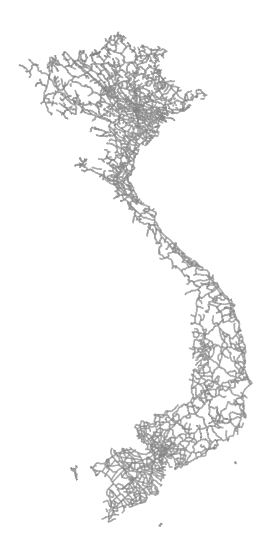

In [4]:
#Plot
f, ax = plt.subplots(figsize=(10, 10))
edges_attr.plot(ax=ax, color='grey', zorder=1)
ax.set_axis_off()
plt.show()

In [5]:
%%time
# Current Hospitals -- stroke facilities in this case
health_facilities =  pd.read_csv(r'../Data/stroke-facs.csv').reset_index()
health_facilities = health_facilities[['index','longitude','latitude','Name_English']]
current_hospitals_ID, current_hospitals = CurrentHospitals(health_facilities, network, nodes)

len(current_hospitals)

CPU times: user 36.8 ms, sys: 14.7 ms, total: 51.5 ms
Wall time: 50.4 ms


80

In [6]:
%%time
# Location of new potential hospitals. 
# Pick "1kmGrid", "5kmGrid", "10kmGrid" or "existing hospitals"

if potential_facilities == "1kmGrid":
    grid = gpd.read_file(r'../Data/potential_location_grid_1.geojson')
    new_hospitals_ID, new_hospitals = NewHospitalsGrid(current_hospitals, grid, network, nodes)
elif potential_facilities == "5kmGrid":
    grid = gpd.read_file(r'../Data/potential_location_grid_5.geojson')
    new_hospitals_ID, new_hospitals = NewHospitalsGrid(current_hospitals, grid, network, nodes)
elif potential_facilities == "10kmGrid":
    grid = gpd.read_file(r'../Data/potential_location_grid_10.geojson')
    new_hospitals_ID, new_hospitals = NewHospitalsGrid(current_hospitals, grid, network, nodes)
elif potential_facilities == "existing hospitals":
    hospitals = gpd.read_file(r'../Data/hospitals_vietnam.geojson')
    new_hospitals_ID, new_hospitals = NewHospitals(current_hospitals, hospitals, network, nodes)
else: print("Pick 1kmGrid, 5kmGrid, 10kmGrid or ExistingHospitals")

len(new_hospitals)


CPU times: user 417 ms, sys: 14.6 ms, total: 431 ms
Wall time: 440 ms


951

In [7]:
%%time

# Population Data
#Round the coordinates to cluster the population. 8 digits: no rounding
digits_rounding = 8

if pop_path == 'facebook':
    read_population = pd.read_csv(r'../Data/pop_fb_2020.csv').reset_index()
    read_population = read_population[['index','longitude','latitude','population_2020']]
elif pop_path == 'worldpop':
    read_population = pd.read_csv(r'../Data/WorldPop_2020_1km.csv').reset_index()

array_household, population = PopulationFB(digits_rounding, read_population, network, nodes)

len(population)

CPU times: user 43.2 s, sys: 6.07 s, total: 49.3 s
Wall time: 49 s


10284976

# Distance matrix calculation

In [8]:
# Determine the smallest and largest threshold
distance_threshold_largest = max(distance_thresholds)
distance_threshold_smallest = min(distance_thresholds)

In [9]:
%%time
# Calculate distance from households to current hospitals
pop_subset = population[['nearest_node','xcoord','ycoord']]
matrix_current = DistanceCalculation(network, current_hospitals, population, pop_subset, distance_threshold_largest)
matrix_current = matrix_current[['ID','pop_dist_road_estrada','household_count','xcoord','ycoord',
                                 'Hosp_ID','hosp_dist_road_estrada','Longitude','Latitude',
                                 'shortest_path_length','euclidean_distance','total_network_distance', 'distance_corrected']]
matrix_current = matrix_current.rename(columns={'ID':'Pop_ID'})



CPU times: user 1min 7s, sys: 25 s, total: 1min 32s
Wall time: 1min 57s


In [10]:
%%time
# Create a subset of the population. 
# This subset contains only the population that is not already within a range of S kilometers
withinSkm = matrix_current[matrix_current.total_network_distance<=distance_threshold_smallest]
withinSkm=withinSkm['Pop_ID'].unique()
population_new = population.drop(population[population.ID.isin(withinSkm)].index.tolist())

CPU times: user 1.25 s, sys: 650 ms, total: 1.9 s
Wall time: 1.9 s


In [11]:
%%time
# Calculate distance to new hospitals
pop_subset = population_new[['nearest_node','xcoord','ycoord']]
matrix_new = DistanceCalculation(network, new_hospitals, population, pop_subset, distance_threshold_largest)
matrix_new = matrix_new[['ID','pop_dist_road_estrada','household_count','xcoord','ycoord',
                                 'Cluster_ID','hosp_dist_road_estrada','Longitude','Latitude',
                                 'shortest_path_length','euclidean_distance','total_network_distance', 'distance_corrected']]
matrix_new = matrix_new.rename(columns={'ID':'Pop_ID'})


CPU times: user 11min 35s, sys: 4min 16s, total: 15min 52s
Wall time: 18min 44s


# Optimization 

In [12]:
%%time
# Add matrix with distances of new hospitals to matrix of distances of current hospitals
matrix_new1 = matrix_new[['Pop_ID','Cluster_ID','distance_corrected']]
matrix_current1 = matrix_current[['Pop_ID','Hosp_ID','distance_corrected']]
matrix_new1.columns = ['Pop_ID','Hosp/Cluster','distance']
matrix_current1.columns = ['Pop_ID','Hosp/Cluster','distance']
df_combined = pd.concat([matrix_current1, matrix_new1],axis=0)
df_combined= df_combined.sort_values(by='Pop_ID')

CPU times: user 5.27 s, sys: 2.22 s, total: 7.5 s
Wall time: 7.72 s


# Model




$\textrm{Maximize } \quad \sum_i v_iy_i $ 

$\textrm{Subject to } \quad x_j = 1 \quad \quad \quad \quad \quad\forall j = 1, ... m $

$ \quad \quad \quad \quad \quad \sum^{M}_{j=m+1} x_j \leq p  $

$ \quad \quad \quad \quad \quad y_i \leq \sum_{j|d_{ij}\leq S} x_j \quad  \forall i \in I$

$ \quad \quad \quad \quad \quad y_i, x_j \in \{0,1\} \quad \quad\forall i \in I, \forall j \in J $

where: 

- $I$ = the index set of households, or clusters of households, indexed by $i = 1, ..., n$. 

- $J$ = the index set of all healthcare sites, where indices $j = 1, ..., m$ are corresponding to the already existing healthcare facilities and indices $j = m+1, ..., M$ are corresponding to potential hospital locations

- $v_i$ = the number of people in (cluster of) household(s) $i$

- $d_{ij}$ = the travel distance from (cluster of) household(s) $i$ to hospital facility $j$

- $S$ = the maximum travel distance from a household (or cluster) to a health care facility

- $p$ = the number of additional hospitals located.

Decision variables:
$
x_j = \begin{cases} 1 & \text{ if hospital } j \text{ is opened} \\
0 & \text{ otherwise}
\end{cases} \\
$
$
y_i = \begin{cases} 1 & \text{ if there is an opened health facility within } S \\ & \text{ kilometers travel distance away from the (cluster of) household(s) } i\\
0 & \text{ otherwise}
\end{cases}
$


In [16]:
nhospitals = [10,20,30,40,50,60,70,80,90,100,150,200,250,300,400,500,750,1000]
df_combined_output = pd.DataFrame()
for each_threshold in distance_thresholds:
    opt_array, tModelling, tSolving = OptimizationModel(array_household, current_hospitals_ID, new_hospitals_ID, df_combined, each_threshold, nhospitals)
    df_opt_outputs = pd.DataFrame(opt_array)
    df_combined_output = df_combined_output.append(df_opt_outputs)
    print("Threshold distance: " + str(each_threshold))
    print("Solving time: " + str(tSolving/60) + ", modelling time: " + str(tModelling/60))
    

Threshold distance: 5
Solving time: 10.816229053338368, modelling time: 29.031239783763887


,km,number_of_new_hospitals,count,array_hosp,array_hh,number_of_hospitals,%
0,5,0,13349321.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",80,13.6
1,5,10,15992823.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",90,16.3
2,5,20,17547733.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",100,17.9
3,5,30,18616468.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",110,19.0
4,5,40,19531882.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",120,19.9
5,5,50,20308493.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",130,20.7
6,5,60,21025636.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",140,21.5
7,5,70,21698453.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",150,22.1
8,5,80,22309726.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",160,22.8
9,5,90,22876358.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",170,23.3


Threshold distance: 10
Solving time: 13.025701065858206, modelling time: 15.94369154771169


,km,number_of_new_hospitals,count,array_hosp,array_hh,number_of_hospitals,%
0,10,0,22553386.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",80,23.0
1,10,10,26468951.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",90,27.0
2,10,20,28700987.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",100,29.3
3,10,30,30543134.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",110,31.2
4,10,40,32099886.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",120,32.8
5,10,50,33484931.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",130,34.2
6,10,60,34758814.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",140,35.5
7,10,70,35912313.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",150,36.7
8,10,80,36914315.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",160,37.7
9,10,90,37866129.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",170,38.6


In [17]:
df_combined_output

,km,number_of_new_hospitals,count,array_hosp,array_hh,number_of_hospitals,%
0,5,0,13349321.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",80,13.6
1,5,10,15992823.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",90,16.3
2,5,20,17547733.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",100,17.9
3,5,30,18616468.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",110,19.0
4,5,40,19531882.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",120,19.9
5,5,50,20308493.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",130,20.7
6,5,60,21025636.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",140,21.5
7,5,70,21698453.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",150,22.1
8,5,80,22309726.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",160,22.8
9,5,90,22876358.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",170,23.3


In [27]:
fig = px.line(df_combined_output.sort_values(by=['km','number_of_hospitals']),
              x='number_of_hospitals',y='%',color='km',
              labels={
                     "number_of_hospitals": "Number of Health Facilities",
                     "%": "Percentage of households with access",
                     "km": "Distance (KM)"
                 })
fig.update_xaxes(range=[0, 960])
fig.update_yaxes(range=[0, 50])

fig.add_annotation(x=165, y=48,
            text="Current health facilities:"+str(len(current_hospitals)),
            showarrow=False,
            arrowhead=1)

fig.add_shape(type="line",
    x0=len(current_hospitals), y0=0, x1=len(current_hospitals), y1=50,
    line=dict(color="RoyalBlue",width=1)
)

fig